# N-Beats for the Sunspots dataset

A quick and dirty application of the n-beats architecture for time series forecasting using the Sunspots dataset

### Imports

Originally, I ran this notebook on google colab. I thought it was easier to import the data directly from my computer than download it on colab

In [ ]:
from google.colab import files
files.upload()

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams["figure.figsize"] = (8, 8)

## Basic block

Here I define the blocks which are the bulk of the n-beats architecture. 

First I create a function to quickly create a MLP architecture, which is the base of each type of block, after, I set up functions to create the expansion coefficients for the interpretable version of n-beats.

Lastly, I define each type of block, Generic, Trend and Seasonal.

In [3]:
def linear_stack(horizon, scale, width, activation=False, bias=True, layers=4):
    """
    Creates a simple MLP, these are the foundation of each type of block proposed in the n-beats paper.
    
    Arguments:
    horizon: The forecast period
    scale: The scale parameter, this times horizon is the lookback period that serves as input to generate predictions
    width: Number of nodes in each layer
    activation: Activation function. Pass False if none required
    bias: Include bias in each linear node?
    layers: Number of layers    
    """
    
    head = [nn.Linear(horizon*scale, width, bias)]
    fc = [nn.Linear(width, width, bias)]
    
    if activation:
        head.append(activation)
        fc.append(activation)
    
    stack = nn.Sequential(*head + fc*(layers-1))
    
    return stack

def create_trend(length, p):
    """
    Creates the expansion coefficients to force an increasing trend in each stack.
    
    Arguments:
    length: Size of the input data
    p: Desired polynomial degree. Typical is 2 to 3
    """
    
    t = np.arange(0, length)/length
    T = torch.tensor([np.power(t ,i) for i in range(p+1)], dtype=torch.float)
    
    return T

def create_season(horizon, scale):
    """
    Creates the expansion coefficients to add regular seasonality in each stack.
    
    Arguments:
    horizon: The forecast period
    scale: The scale parameter, this times horizon is the lookback period that serves as input to generate predictions
    """
    backcast_size = horizon*scale
    
    frequency = np.append(np.zeros(1), np.arange(scale, scale / 2 * horizon) / scale).reshape((1, -1))
    backcast_grid = 2 * np.pi * (np.arange(backcast_size) / horizon).reshape((-1, 1)) * frequency
    forecast_grid = 2 * np.pi * (np.arange(horizon) / horizon).reshape((-1, 1)) * frequency
    
    return torch.tensor(backcast_grid, dtype=torch.float), torch.tensor(forecast_grid, dtype=torch.float)

In [4]:
class GenericBlock(nn.Module):
    def __init__(self, horizon, scale, width, layers, theta_len):
        """
        The generic block as described on the paper. This might not generate interpretable outputs.

        Arguments:
        horizon: The forecast period
        scale: The scale parameter, this times horizon is the lookback period that serves as input to generate predictions
        width: Number of nodes in each layer
        layers: Number of layers    
        theta_len: The size of the non-interpretable expansion coefficients
        """
        super().__init__()
            
        backcast_length = horizon*scale
        
        self.fc_layers = linear_stack(horizon, scale, width, activation=nn.ReLU(inplace=True), bias=True, layers=layers)
        self.backcast = nn.Sequential(nn.Linear(width, theta_len, bias=False), 
                                     nn.Linear(theta_len, backcast_length, bias=True)
                                     )
        
        self.forecast = nn.Sequential(nn.Linear(width, theta_len, bias=False), 
                                     nn.Linear(theta_len, horizon, bias=True)
                                     )
        
    def forward(self, x):
        x1 = self.fc_layers(x)
        backcast = self.backcast(x1)
        forecast = self.forecast(x1)
        
        return backcast, forecast

In [5]:
class TrendBlock(nn.Module):
    def __init__(self, horizon, scale, width, layers, p):
        """
        The trend block as described on the paper. Outputs from this block should resemble a linear trend.
    
        Arguments:
        horizon: The forecast period
        scale: The scale parameter, this times horizon is the lookback period that serves as input to generate predictions
        width: Number of nodes in each layer
        layers: Number of layers 
        p: Desired polynomial degree. Typical is 2 to 3
        """
        
        super().__init__()
        
        self.size = p+1
        
        backcast_length = horizon*scale
        theta_len = 2*self.size
        
        self.trend_back = nn.Parameter(create_trend(backcast_length, p), requires_grad=False)
        self.trend_forward = nn.Parameter(create_trend(horizon, p), requires_grad=False)
        
        self.fc_layers = linear_stack(horizon, scale, width, activation=nn.ReLU(inplace=True), bias=True, layers=layers)
        self.basis = nn.Linear(width, theta_len, bias=False)
                                     
    def forward(self, x):
        x1 = self.fc_layers(x)
        theta = self.basis(x1)
        backcast = torch.einsum('bp,pt->bt', theta[:, :self.size], self.trend_back)
        forecast = torch.einsum('bp,pt->bt', theta[:, self.size:], self.trend_forward)

        return backcast, forecast

In [6]:
class SeasonalBlock(nn.Module):
    def __init__(self, horizon, scale, width, layers):
        """
        The seasonal block as described on the paper. Outputs from this block should resemble a sinoid or cosine function.

        Arguments:
        horizon: The forecast period
        scale: The scale parameter, this times horizon is the lookback period that serves as input to generate predictions
        width: Number of nodes in each layer
        layers: Number of layers 
        """
        super().__init__()

        backcast_length = horizon*scale
        theta_len = 4 * int(np.ceil(scale / 2 * horizon) - (scale - 1))

        backcast_grid, forecast_grid = create_season(horizon, scale)

        backcast_grid = torch.transpose(backcast_grid, 0, 1)
        forecast_grid = torch.transpose(forecast_grid, 0, 1)

        self.fc_layers = linear_stack(horizon, scale, width, activation=nn.ReLU(inplace=True), bias=True, layers=layers)
        self.basis = nn.Linear(width, theta_len, bias=False)

        self.cos_backcast = nn.Parameter(torch.cos(backcast_grid), requires_grad=False)
        self.sin_backcast = nn.Parameter(torch.sin(backcast_grid), requires_grad=False)

        self.cos_forecast = nn.Parameter(torch.cos(forecast_grid), requires_grad=False)
        self.sin_forecast = nn.Parameter(torch.sin(forecast_grid), requires_grad=False)

    def forward(self, x):        
        x1 = self.fc_layers(x)
        x1 = self.basis(x1)
        
        quarters = x1.shape[1]//4
        
        backcast_cos = torch.einsum('bp,pt->bt', x1[:, :quarters], self.cos_backcast)
        backcast_sin = torch.einsum('bp,pt->bt', x1[:, quarters:2*quarters], self.sin_backcast)
        backcast = backcast_cos + backcast_sin
        
        forecast_cos = torch.einsum('bp,pt->bt', x1[:, 2*quarters:3*quarters], self.cos_forecast)
        forecast_sin = torch.einsum('bp,pt->bt', x1[:, 3*quarters:], self.sin_forecast)
        forecast = forecast_cos + forecast_sin
                
        return backcast, forecast 
    

### Stack

Code to create a stack from a list of blocks. Might be redundant with the module that creates the network

In [7]:
class NStack(nn.Module):
    def __init__(self, horizon, block, num_blocks, weight_sharing):
        """
        Defines a stack which is a series of blocks which decompose the input data
        
        Arguments:
        horizon: The forecast period
        block: A list composed of the block objects
        num_blocks: Number of blocks in each stack
        weight_sharing: Should every block in the stack have the same weights?
        """
        super().__init__()
        
        self.horizon = horizon
        self.num_blocks = num_blocks
        self.weight_sharing = weight_sharing
        
        if not self.weight_sharing:
            block_list = [block]*self.num_blocks
            self.blocks = nn.ModuleList(block_list)
        else:
            self.blocks = block
        
    def forward(self, x, batch_size):
        forecasts = torch.empty((batch_size, self.num_blocks, self.horizon))
        for bi in range(self.num_blocks):
            if self.weight_sharing:
                backcast, forecast = self.blocks(x)
            else:
                block = self.blocks[bi]
                backcast, forecast = block(x)
            x = x - backcast
            forecasts[:, bi, :] = forecast
        
        return x, forecasts.sum(1)

### Network

Module to create the network architecture and some quick functions to implement the two types of n-beats described on the paper

In [8]:
class NBeats(nn.Module):
    def __init__(self, horizon, block_list, num_blocks, weight_sharing):
        """
        Defines the network architecture
        
        Arguments:
        horizon: The forecast period
        block: A list composed of the block objects
        num_blocks: Number of blocks in each stack
        weight_sharing: Should every block in the stack share have the same weights?
        """
        super().__init__()
        stacks_list = [NStack(horizon, block, num_blocks, weight_sharing) for block in block_list]
        
        self.horizon = horizon
        self.num_stacks = len(block_list)
        self.stacks = nn.ModuleList(stacks_list)
        
    def forward(self, x, batch_size):
        forecasts = torch.empty((batch_size, self.num_stacks, self.horizon))
        for s in range(len(self.stacks)):
            stack = self.stacks[s]
            backcast, forecast = stack(x, batch_size)
            x = x - backcast
            forecasts[:, s, :] = forecast
        
        if torch.cuda.is_available():
            x, forecasts = x.cuda(), forecasts.cuda()
        
        return x, forecasts.sum(1)

In [9]:
def create_nbeats_g(horizon, scale, width, layers, theta_len, num_blocks, num_stacks):
    
    block_list = [GenericBlock(horizon, scale, width, layers, theta_len) for _ in range(num_stacks)]
    
    return NBeats(horizon, block_list, num_blocks, False)

def create_nbeats_i(horizon, scale, t_width, t_layers, t_p, s_width, s_layers, num_blocks):
    
    block_list = [TrendBlock(horizon, scale, t_width, t_layers, t_p), SeasonalBlock(horizon, scale, s_width, s_layers)]
    
    return NBeats(horizon, block_list, num_blocks, True)

### Sunspots

Let's see how this neural net performs on some real data. Differently from the paper, I impelemnt just one model instead of an ensemble of many n-beats with different parameters. But still, the model performs very well

Starting, by reading and quickly plotting the data

In [10]:
sunspot = pd.read_csv('monthly-sunspots.txt')
data = sunspot['Sunspots'].to_numpy()

data

array([58. , 62.6, 70. , ..., 55.8, 33.3, 33.4])

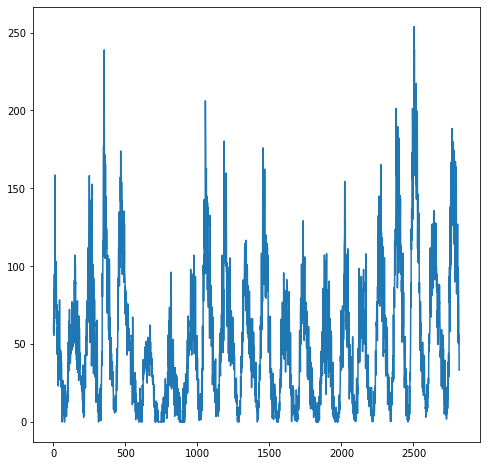

In [11]:
plt.plot(data)

I split the data considering the first 80% as our train set and the rest will serve as validation

In [12]:
split = 0.8
n = data.shape[0]

train, validation = data[:int(n*split)], data[int(n*split):]

Our strategy to fit the model is to run _n_ batches instead of epochs. For this we will need a function to generate a certain amount of batches on demand.
The idea here is that by running a sufficient amount of totally random batches, we will see enough data to generalize well.

I also created a quick function to breakdown the validation data in the maximum amount of splits given the forecast period

In [13]:
def generate_batch(data, h, scale, batch_size): 
    """
    Pick batch_size points at random and creates a lookback period to serve as an input to the model
    
    Arguments:
    data: The training array in which to create the batches from
    h: Lookback period
    scale: The scale parameter, this times h is the lookback period that serves as input to generate predictions
    """
    
    n = data.shape[0]
    
    indexes = np.random.randint(low=h*scale, high=n-h, size=batch_size)
    x = np.zeros((batch_size, h*scale))
    y = np.zeros((batch_size, h))
    
    for i in range(batch_size):
        x[i, :] = data[indexes[i]-(h*scale):indexes[i]]
        y[i, :] = data[indexes[i]:indexes[i]+h]
    
    return x, y        

def generate_validation(data, h, scale):
    """
    Creates the maximum amount of breaks in the data for a given lookback and forecast period.
    
    Arguments:
    data: The validation array in which to split into validation 'batches'
    h: Lookback period
    scale: The scale parameter, this times h is the lookback period that serves as input to generate predictions
    """
    n_valid = data.shape[0]

    x_valid = np.zeros((n_valid//(h*scale)-1, h*scale))
    y_valid = np.zeros((n_valid//(h*scale)-1, h))

    for i in range(0, (n_valid//(h*scale))-1):
        start_x = i*h*scale
        end_x = (i+1)*h*scale
    
        start_y = end_x
        end_y = start_y + h
    
        x_valid[i, :] = validation[start_x:end_x]
        try:
            y_valid[i, :] = validation[start_y:end_y]
        except ValueError:
            pass
    
    return x_valid, y_valid

#### Training loop

A simple training loop. In functional form to facilitate its use

In [14]:
def train_loop(model, train, x_valid, y_valid, optimizer, batch_size, n_batches, print_every=25):
    if on_gpu:
        model.cuda()
        x_valid = torch.from_numpy(x_valid).float().cuda()
        y_valid = torch.from_numpy(y_valid).float().cuda()

    counter = 0

    for i in range(n_batches):
        counter += 1
        train_loss = []
        model.train()
        model.zero_grad()
        
        x, y = generate_batch(data=train, h=h, scale=scale, batch_size=batch_size)
        x, y = torch.from_numpy(x).float(), torch.from_numpy(y).float()
        if on_gpu:
            x, y = x.cuda(), y.cuda()
        
        backcasts, forecasts = model(x, batch_size)
        
        loss = criterion(forecasts, y)
        loss.backward()
        optimizer.step()
        
        if counter % print_every == 0:
            with torch.no_grad():
                model.eval()
                val_backcasts, val_forecasts = model(x_valid, x_valid.shape[0])
                val_loss = criterion(val_forecasts, y_valid)
            
            print(f'Batch: {i+1}/{n_batches}', f'Train loss: {loss:.4f}', f'Validation loss: {val_loss:.4f}')
            

Defining some generic obejcts.

We will fit both the generic and interpretable versions of the neural network. For the loss function we will use the Mean Absolute Deviation.

In [15]:
h = 10
scale = 2

generic_model = create_nbeats_g(horizon=h, scale=scale, width=512, layers=4, theta_len=64, num_blocks=1, num_stacks=30)
interpretable_model = create_nbeats_i(h, scale, t_width=256, t_layers=4, t_p=2, s_width=2048, s_layers=4, num_blocks=3)

optimizer_g = optim.Adam(generic_model.parameters())
optimizer_i = optim.Adam(interpretable_model.parameters())
criterion = nn.L1Loss()
x_valid, y_valid = generate_validation(validation, h, scale)

on_gpu = torch.cuda.is_available()

train_loop(generic_model, train, x_valid, y_valid, optimizer_g, 64, 200, 25)

Batch: 25/200 Train loss: 14.8836 Validation loss: 21.4770
Batch: 50/200 Train loss: 13.2504 Validation loss: 20.1015
Batch: 75/200 Train loss: 16.8650 Validation loss: 18.5867
Batch: 100/200 Train loss: 11.9939 Validation loss: 20.0640
Batch: 125/200 Train loss: 13.2255 Validation loss: 19.9418
Batch: 150/200 Train loss: 13.9231 Validation loss: 20.9572
Batch: 175/200 Train loss: 11.8394 Validation loss: 19.1860
Batch: 200/200 Train loss: 12.9281 Validation loss: 18.6853


Looking at the validation data, the model seems to perform very well

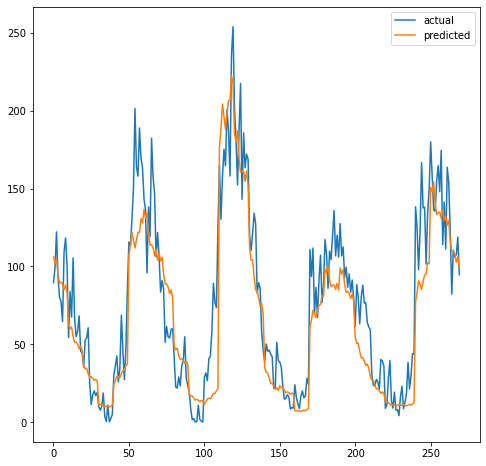

In [62]:
with torch.no_grad():
    plot_y = y_valid.reshape(-1)
    plot_x = torch.from_numpy(x_valid).float().cuda()
    _, g_forecasts = generic_model(plot_x, plot_x.shape[0])

    plt.plot(range(plot_y.shape[0]), plot_y, label='actual')
    plt.plot(range(plot_y.shape[0]), g_forecasts.view(-1).cpu(), label='predicted')
    plt.legend()

    plt.show()

The interpretable architecture is not very different

In [17]:
train_loop(interpretable_model, train, x_valid, y_valid, optimizer_i, 64, 300, 25)

Batch: 25/300 Train loss: 12.6153 Validation loss: 19.9858
Batch: 50/300 Train loss: 11.7234 Validation loss: 19.1235
Batch: 75/300 Train loss: 15.2080 Validation loss: 19.1017
Batch: 100/300 Train loss: 14.8290 Validation loss: 21.7467
Batch: 125/300 Train loss: 13.2110 Validation loss: 19.0811
Batch: 150/300 Train loss: 13.2287 Validation loss: 18.8998
Batch: 175/300 Train loss: 11.7402 Validation loss: 18.1743
Batch: 200/300 Train loss: 15.3141 Validation loss: 18.9500
Batch: 225/300 Train loss: 14.3303 Validation loss: 19.3169
Batch: 250/300 Train loss: 12.0256 Validation loss: 17.7729
Batch: 275/300 Train loss: 13.0475 Validation loss: 19.8856
Batch: 300/300 Train loss: 13.2602 Validation loss: 17.8610


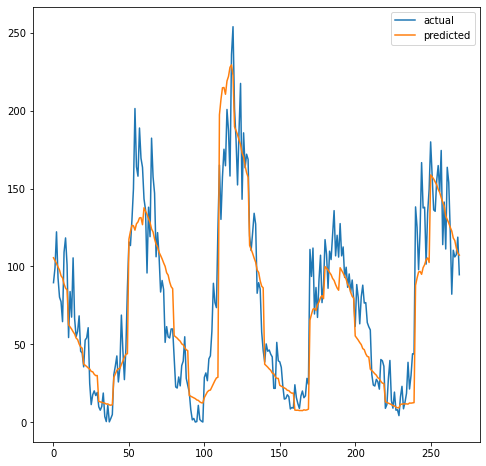

In [63]:
with torch.no_grad():
    plot_y = y_valid.reshape(-1)
    _, i_forecasts = interpretable_model(plot_x, plot_x.shape[0])

    plt.plot(range(plot_y.shape[0]), plot_y, label='actual')
    plt.plot(range(plot_y.shape[0]), i_forecasts.view(-1).cpu(), label='predicted')
    plt.legend()

    plt.show()

We can peek at the architectures to see if they produce any interesting output. 

In both cases, it appears that the data is simple enough to have all the variation picked up by the first block, the rest appears to just "model" the noise

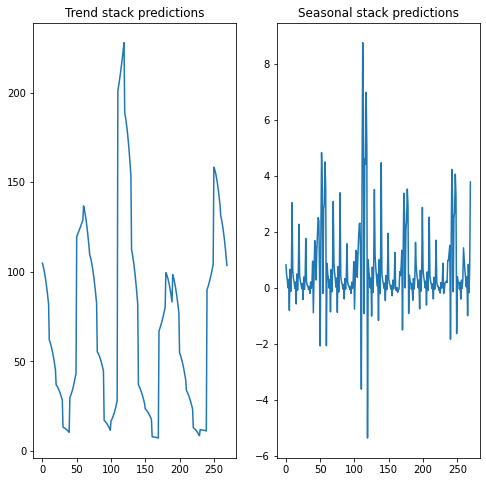

In [64]:
with torch.no_grad():
    fig, ax = plt.subplots(ncols=2)

    trend_backcast, trend_forecast = interpretable_model.stacks[0](plot_x, plot_x.shape[0])
    ax[0].plot(range(plot_y.shape[0]), trend_forecast.view(-1).cpu())
    ax[0].set_title('Trend stack predictions')

    i_x = plot_x - trend_backcast
    season_backcast, season_forecast = interpretable_model.stacks[1](i_x, plot_x.shape[0])
    ax[1].plot(range(plot_y.shape[0]), season_forecast.view(-1).cpu())
    ax[1].set_title('Seasonal stack predictions')

    plt.show()

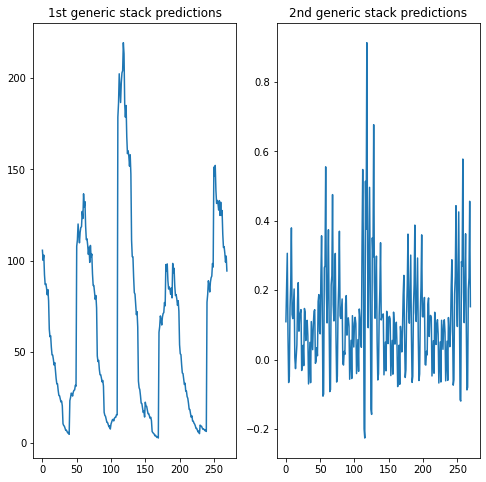

In [65]:
with torch.no_grad():
    fig, ax = plt.subplots(ncols=2)

    gen0_backcast, gen0_forecast = generic_model.stacks[0](plot_x, plot_x.shape[0])
    ax[0].plot(range(plot_y.shape[0]), gen0_forecast.view(-1).cpu())
    ax[0].set_title('1st generic stack predictions')

    g_x = plot_x - gen0_backcast
    gen1_backcast, gen1_forecast = generic_model.stacks[1](g_x, plot_x.shape[0])
    ax[1].plot(range(plot_y.shape[0]), gen1_forecast.view(-1).cpu())
    ax[1].set_title('2nd generic stack predictions')
    
    plt.show()